In [180]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [45]:
df = pd.read_csv("df_fe_without_preprocessing_train.csv")
df[df.isna().any(axis = 1)]

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
105780,105780,174363,174364,How can I develop android app?,NaN,0,2,2,30,0,6,1,0,7,0.0,4,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0,1,2,32,0,7,1,0,8,0.0,3,1
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0,1,1,0,123,1,21,0,18,0.0,2,0


In [47]:
df = df.fillna('')

### Preprocessing:
1. Remove html tags, punctuations, stop-words
2. Stem words
3. Expand contractions


In [48]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aswat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
def preprocess(x):
    x = str(x).lower()

    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
# \w, \W: ANY ONE word/non-word character. For ASCII, word characters are [a-zA-Z0-9_]
    pattern = re.compile('\W')
    
    if type(x) == type(''): # to check for string
        x = re.sub(pattern, ' ', x) # replace non word characters with space

# use beautiful soup to extract data from html

    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x


#### Advanced Feature Extraction

In [50]:
import distance
import nltk
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import sklearn
from sklearn.manifold import TSNE

In [51]:
def get_token_features(q1,q2):
    token_features = [0.0]*10 # to store features
    # getting tokens from sentences
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # get non stop words in questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # get all stop words in questions    
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    #get common non stopwords from question pairs
    common_word_count = len(q1_words.intersection(q2_words))

    #get common stop words from question pairs    
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    #get common tokens from question pairs
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    #build features
    SAFE_DIV = 0.0001 #to avoid division by 0
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV) 
    
    #last word and first word of question are same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    #abs lenght diff
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

def get_longest_substr_ratio(a,b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    #preprocessing questions
    df['question1'] = df['question1'].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    
    #appending features to dataset
    token_features = df.apply(lambda x: get_token_features(x['question1'],x['question2']), axis = 1)
    # check shape: token_features.shape
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    # using Fuzzy Features 
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    # https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis = 1)
    df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis = 1)
    df['fuzz_ratio']            = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis=1)
    df['fuzz_partial_ratio']    = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
    df['longest_substr_ratio']  = df.apply(lambda x: get_longest_substr_ratio(x['question1'], x['question2']), axis=1)
    return df

In [53]:
df = pd.read_csv("train.csv")
df = extract_features(df)
df.to_csv("nlp_features_train.csv", index=False)

In [54]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


### Analyzing Extracted Features

In [55]:
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [176]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

# data points for duplicate questions and non duplicate questions

p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
n = np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

# writing to text file
#p[16616:16618]
#p[28600:28602]
#p[33274:33276]
#p[16616] =''.join([i if ord(i) < 128 else '' for i in p[16616]])
#p[16617] =''.join([i if ord(i) < 128 else '' for i in p[16617]])
#p[28600] =''.join([i if ord(i) < 128 else '' for i in p[28600]])
#p[28601] =''.join([i if ord(i) < 128 else '' for i in p[28601]])
#p[33274] =''.join([i if ord(i) < 128 else '' for i in p[33274]])
#p[33275] =''.join([i if ord(i) < 128 else '' for i in p[33275]])
#np.savetxt('train_p.txt', p, delimiter=' ', fmt = '%s')
#np.savetxt('train_n.txt', n, delimiter=' ', fmt = '%s')

In [177]:
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s', encoding='utf8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt = '%s',encoding='utf8')

In [178]:
print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [198]:
import codecs
pf = codecs.open("train_p.txt", "r", "utf-8")
textp_w = pf.read()
nf = codecs.open("train_n.txt", "r", "utf-8")
textn_w = nf.read()

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))


Total number of words in duplicate pair questions : 16408603
Total number of words in non duplicate pair questions : 33703657


Generating WordClouds

In [204]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
stopwords = set(stop_words)

In [209]:
stopwords.add('get')
stopwords.add(' ')
#stopwords.remove('not')

#stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
#stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")

Word Cloud for Duplicate Question pairs


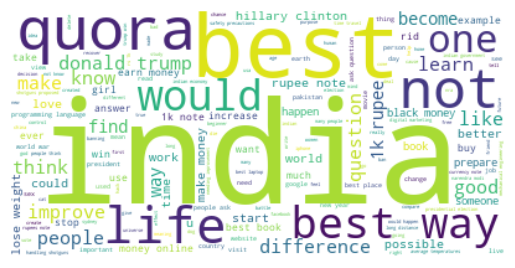

In [210]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords = stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()   

Word Cloud for Non Duplicate Question pairs


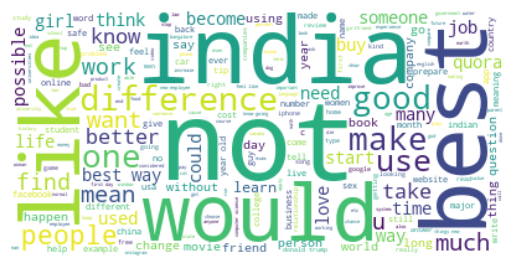

In [211]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()  

Size of word indicating frequency of its occurence in each category

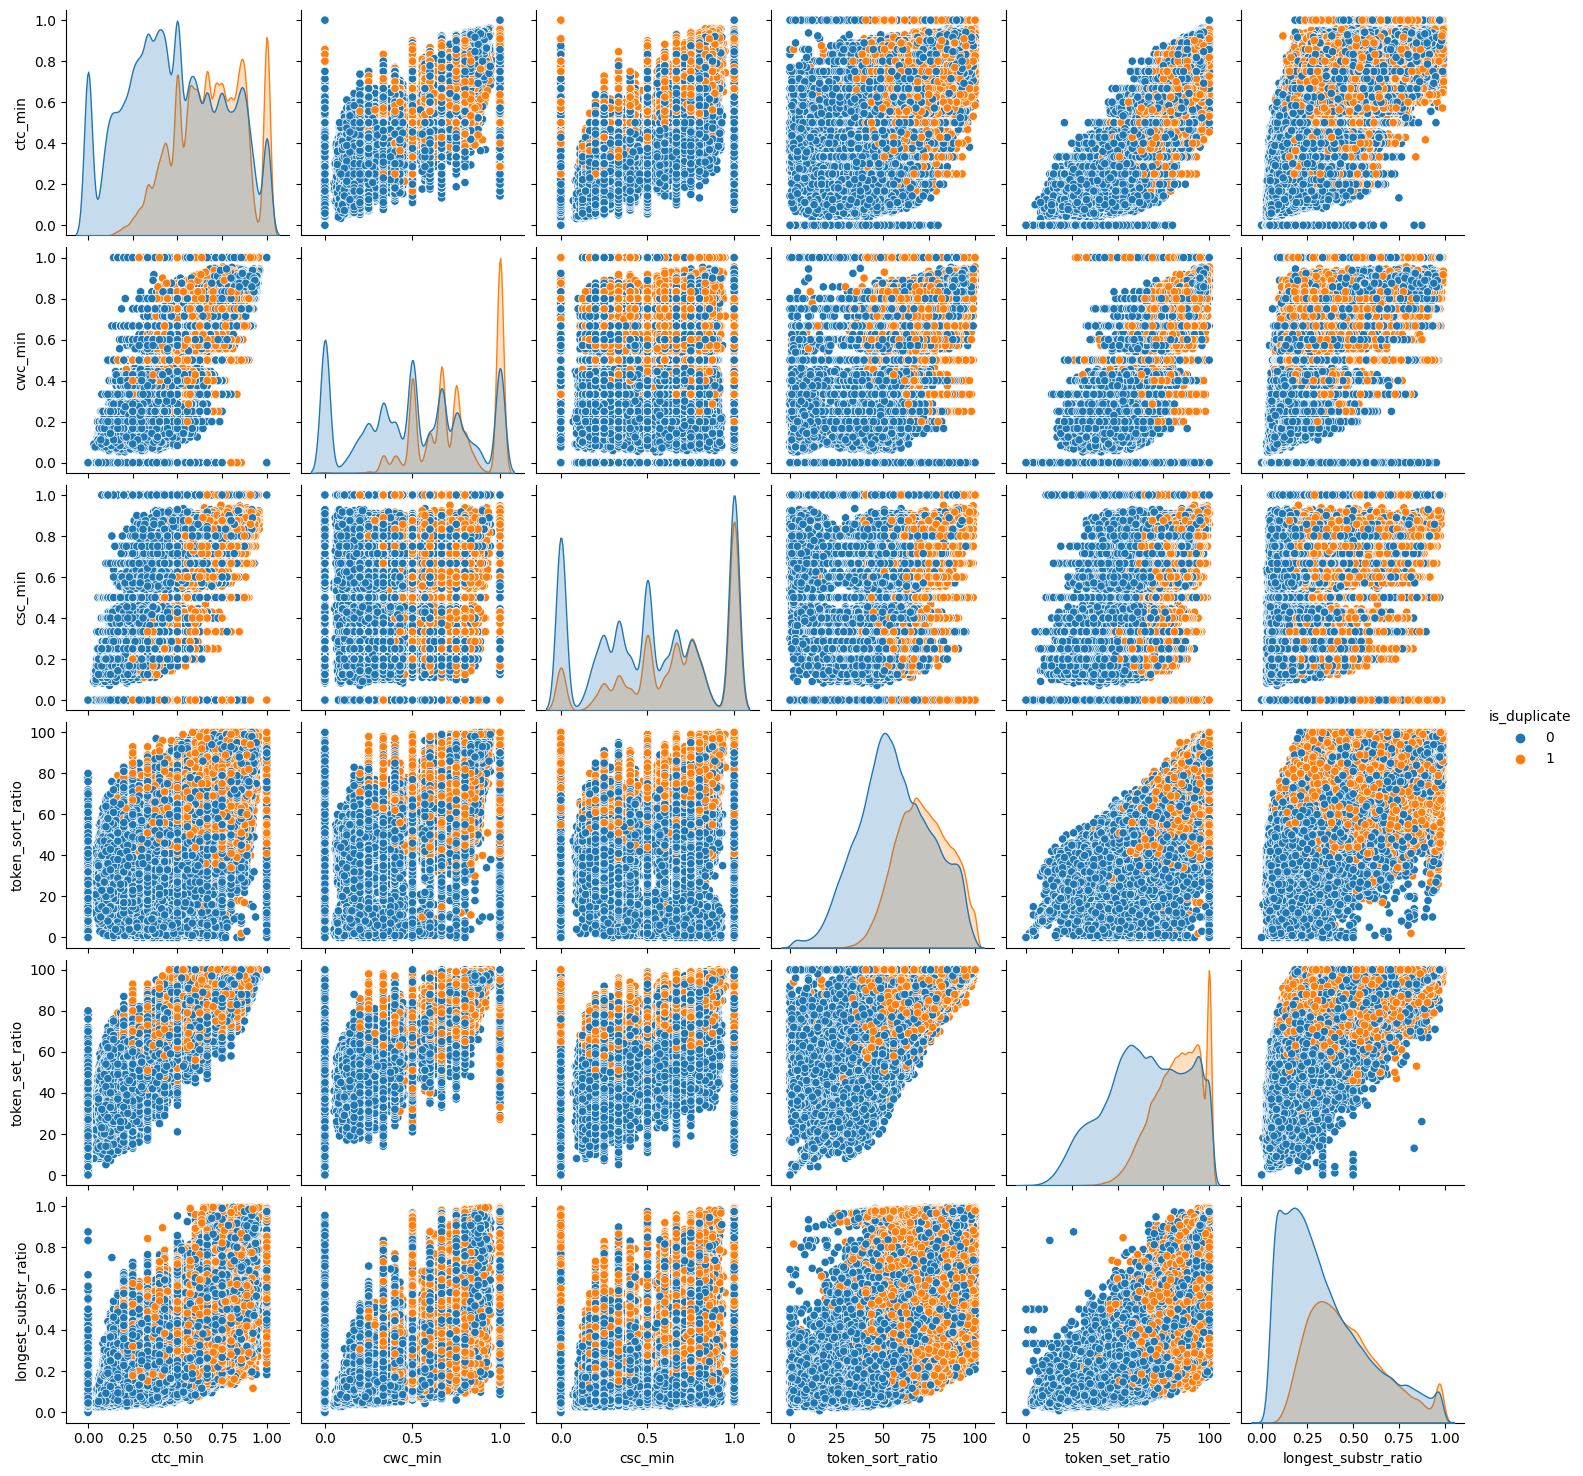

In [214]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio','token_set_ratio','longest_substr_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio','token_set_ratio','longest_substr_ratio'])
plt.show()


There's some overlap and some seperation; we would get partial predictability

C:\Users\aswat\AppData\Local\Temp\ipykernel_11612\1204122265.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
C:\Users\aswat\AppData\Local\Temp\ipykernel_11612\1204122265.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1"

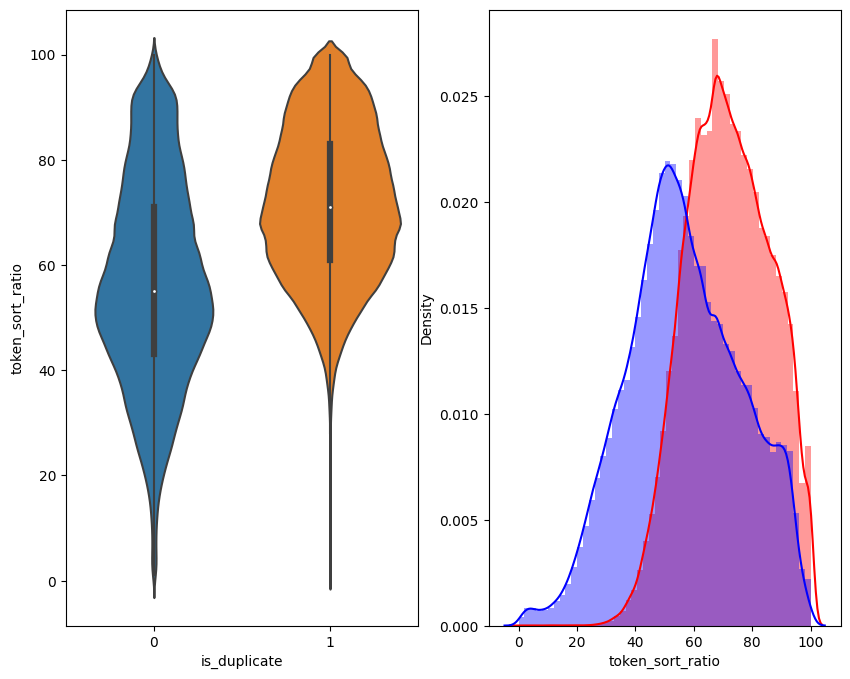

In [215]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

C:\Users\aswat\AppData\Local\Temp\ipykernel_11612\2783903235.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
C:\Users\aswat\AppData\Local\Temp\ipykernel_11612\2783903235.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'r

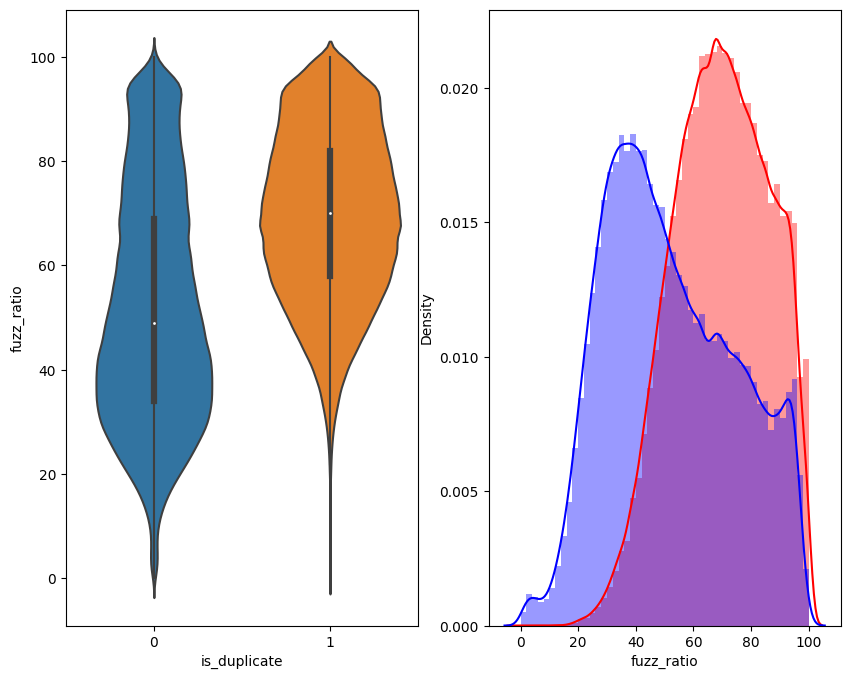

In [216]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

 token_sort_ratio and fuzz_ratio also provide some separability as their PDFs partially overlap

In [ ]:
VISUALIZATION to confirm seperability

In [217]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [218]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.070s...
[t-SNE] Computed neighbors for 5000 samples in 0.327s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.131928
[t-SNE] Computed conditional probabilities in 0.187s
[t-SNE] Iteration 50: error = 85.5763092, gradient norm = 0.0873597 (50 iterations in 1.226s)
[t-SNE] Iteration 100: error = 71.0175171, gradient norm = 0.0140214 (50 iterations in 0.752s)
[t-SNE] Iteration 150: error = 69.0701675, gradient norm = 0.0075740 (50 iterations in 0.659s)
[t-SNE] Iteration 200: error = 68.2074738, gradient norm = 0.0055327 (50 iterations in 0.706s)
[t-SNE] Iteration 250: error = 67.6851959, gradient norm = 0.0043606

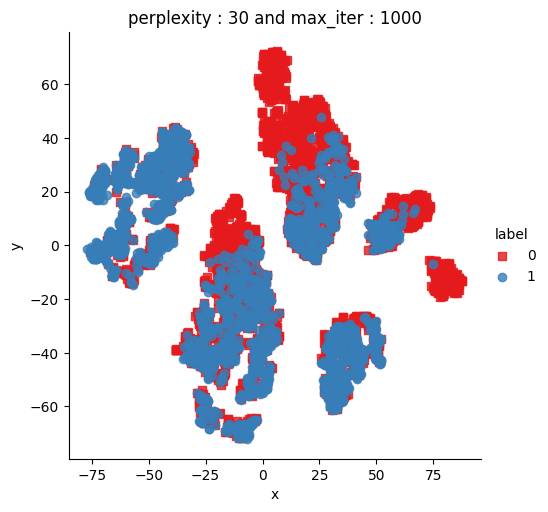

In [220]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

A sample of 5000 datapoints were taken and dimensionality reduction was performed using t-SNE. The dimensionality was reduced to 2. The regions of seperation re-assures our approach.